In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import neptune
from MODULES.utilities_neptune import log_object_as_artifact, log_model_summary, log_last_ckpt, log_img_only, log_dict_metrics
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_all_from_dictionary, plot_label_contours
from MODULES.utilities_visualization import plot_reconstruction_and_inference, plot_generation, plot_segmentation
from MODULES.utilities_ml import ConditionalRandomCrop, SpecialDataSet, process_one_epoch
from MODULES.graph_clustering import GraphSegmentation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

params = load_json_as_dict("./ML_parameters.json")

neptune.set_project(params["neptune_project"])
exp: neptune.experiments.Experiment = \
    neptune.create_experiment(params=flatten_dict(params),
                              upload_source_files=["./main.py", "./MODULES/vae_parts.py", 
                                                   "./MODULES/vae_model.py", "./MODULES/encoders_decoders.py"],
                              upload_stdout=True,
                              upload_stderr=True)

# Get the training and test data
preprocessed = load_obj("./data_train.pt")
img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()
assert len(img_torch.shape) == len(roi_mask_torch.shape) == 4
# print("GPU GB after opening data ->",torch.cuda.memory_allocated()/1E9)

BATCH_SIZE = params["simulation"]["batch_size"]
SIZE_CROPS = params["input_image"]["size_raw_image"]
N_TEST = params["simulation"]["N_test"]
N_TRAIN = params["simulation"]["N_train"]
conditional_crop_test = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                              min_roi_fraction=0.9, n_crops_per_image=N_TEST)

conditional_crop_train = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                               min_roi_fraction=0.9, n_crops_per_image=N_TRAIN)

test_data = conditional_crop_test.crop(img=img_torch,
                                       roi_mask=roi_mask_torch)
# print("GPU GB after defining test data ->",torch.cuda.memory_allocated()/1E9)


test_loader = SpecialDataSet(img=test_data,
                             store_in_cuda=False,
                             shuffle=False,
                             drop_last=False,
                             batch_size=BATCH_SIZE)
test_batch_example_fig = test_loader.check_batch()
log_img_only(name="test_batch_example", fig=test_batch_example_fig, experiment=exp)

train_loader = SpecialDataSet(img=img_torch,
                              roi_mask=roi_mask_torch,
                              data_augmentation=conditional_crop_train,
                              store_in_cuda=False,
                              shuffle=True,
                              drop_last=True,
                              batch_size=BATCH_SIZE)
train_batch_example_fig = train_loader.check_batch()
log_img_only(name="train_batch_example", fig=train_batch_example_fig, experiment=exp)
# print("GPU GB after train_loader ->",torch.cuda.memory_allocated()/1E9)

# Make a batch of reference images by cropping the train_data at consecutive locations
reference_imgs_list = []
crop_size = params["input_image"]["size_raw_image"]
for ni in range(2):
    i = 1060 + ni * crop_size
    for nj in range(4):
        j = 2100 + nj * crop_size
        reference_imgs_list.append(img_torch[..., i:i+crop_size, j:j+crop_size])
reference_imgs = torch.cat(reference_imgs_list, dim=-4)
if torch.cuda.is_available():
    reference_imgs = reference_imgs.cuda()
_ = show_batch(reference_imgs,
               n_padding=4,
               figsize=(12, 12),
               title="reference imgs",
               neptune_name="reference_imgs")

# Instantiate model, optimizer and checks
vae = CompositionalVae(params)
log_model_summary(vae)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])
# print("GPU GB after model and optimizer ->",torch.cuda.memory_allocated()/1E9)

imgs_out = vae.inference_and_generator.unet.show_grid(reference_imgs)
unet_grid_fig = show_batch(imgs_out[:, 0], normalize_range=(0.0, 1.0), neptune_name="unet_grid")

# Check the constraint dictionary
print("simulation type = "+str(params["simulation"]["type"]))
    
if params["simulation"]["type"] == "scratch":
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif params["simulation"]["type"] == "resume":
    
    # ckpt = file2ckpt(path="ckpt.pt", device=None)
    ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=optimizer,
                   overwrite_member_var=True)

    epoch_restart = ckpt.get('epoch', 0)
    history_dict = ckpt.get('history_dict', {})
    try:
        min_test_loss = min(history_dict.get("test_loss", 999999))
    except:
        min_test_loss = 999999
    
elif params["simulation"]["type"] == "pretrained":

    # ckpt = file2ckpt(path="ckpt.pt", device=None)
    ckpt = file2ckpt(path="ckpt.pt", device='cpu')

    load_from_ckpt(ckpt=ckpt,
                   model=vae,
                   optimizer=None,
                   overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
else:
    raise Exception("simulation type is NOT recognized")
    

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/smFISH/e/SMFIS-252
Dataset lenght: 64
img.shape torch.Size([64, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.7457)
Dataset lenght: 512
img.shape torch.Size([512, 1, 2688, 2688])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.8647)
simulation type = resume


In [10]:
min(history_dict.get("test_loss", 999999))

TypeError: 'int' object is not iterable

In [6]:
ckpt["epoch"]

3

In [3]:
# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])


TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]
torch.cuda.empty_cache()

# # Check segmentation WITH and WITHOUT tiling
img_to_segment = train_loader.img[0, :, 1000:1300, 2100:2400]
roi_mask_to_segment = train_loader.roi_mask[0, :, 1000:1300, 2100:2400]

#img_to_segment = train_loader.img[0, :, 1060:1360, 2100:2400]
#roi_mask_to_segment = train_loader.roi_mask[0, :, 1060:1360, 2100:2400]

# check simple segmentation
crop_size = params["input_image"]["size_raw_image"]
small_img_to_segment = img_to_segment[None, ..., :crop_size, :crop_size]
if torch.cuda.is_available():
    small_img_to_segment = small_img_to_segment.cuda()
segmentation: Segmentation = vae.segment(batch_imgs=small_img_to_segment)
plot_segmentation(segmentation, epoch="", prefix="seg_", postfix="_tiling")

# tiling segmentation
tiling: Segmentation = vae.segment_with_tiling(single_img=img_to_segment,
                                               roi_mask=roi_mask_to_segment,
                                               crop_size=None,
                                               stride=(40, 40),
                                               n_objects_max_per_patch=None,
                                               prob_corr_factor=None,
                                               overlap_threshold=None,
                                               radius_nn=10,
                                               batch_size=64)
# log_object_as_artifact(name="tiling", obj=tiling, verbose=True)
tiling_fig = plot_tiling(tiling, neptune_name="tiling_before_graph")

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/dalessioluca/smFISH/e/SMFIS-248
Dataset lenght: 64
img.shape torch.Size([64, 1, 80, 80])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.7457)
Dataset lenght: 512
img.shape torch.Size([512, 1, 2688, 2688])
img.dtype torch.float32
img.device cpu
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0.0302) tensor(0.8647)
simulation type = resume


AttributeError: 'dict' object has no attribute 'epoch'

In [ ]:
print("ciao")

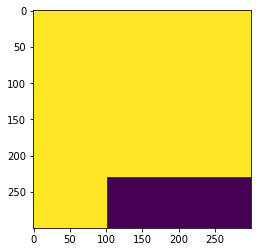

In [27]:
plt.imshow(roi_mask_to_segment[0])

In [36]:

tiling: Segmentation = vae.segment_with_tiling(single_img=img_to_segment,
                                               roi_mask=roi_mask_to_segment,
                                               crop_size=None,
                                               stride=(40, 40),
                                               n_objects_max_per_patch=None,
                                               prob_corr_factor=None,
                                               overlap_threshold=None,
                                               radius_nn=10,
                                               batch_size=64)
# log_object_as_artifact(name="tiling", obj=tiling, verbose=True)
tiling_fig = plot_tiling(tiling)

Each pixel will be segmented 4 times
I am going to process 71 patches
0 out of 1 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
1 out of 1 -> batch_of_imgs.shape = torch.Size([7, 1, 80, 80])
tensor([64, 65, 66, 67, 68, 69, 70])


In [1]:
epoch = 3
ckpt = create_ckpt(model=vae,
                   optimizer=optimizer,
                   epoch=epoch,
                   hyperparams_dict=params,
                   history_dict=history_dict)

NameError: name 'create_ckpt' is not defined

In [41]:
log_object_as_artifact(name="last_ckpt", obj=ckpt) 

In [37]:
print("ciao")

ciao


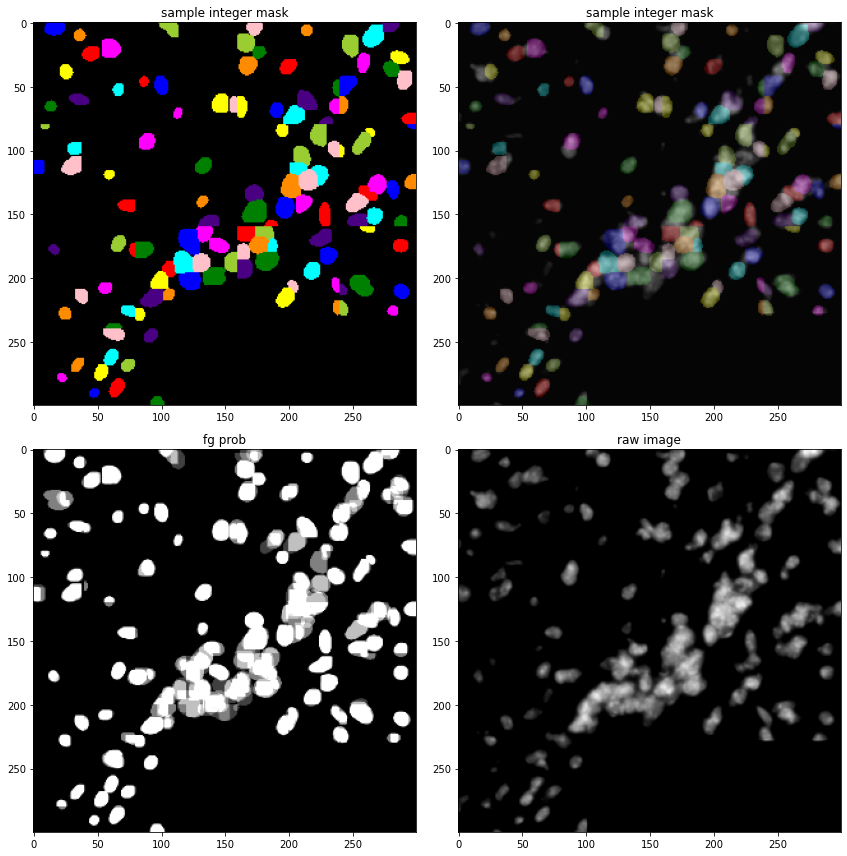

In [38]:
tiling_fig

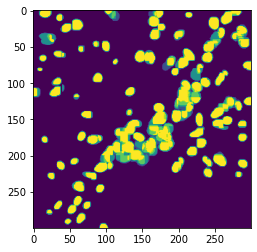

In [34]:
plt.imshow(tiling.fg_prob[0,0])

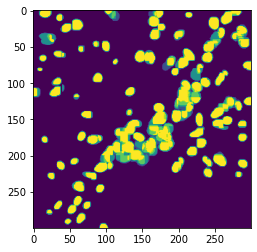

In [35]:
plt.imshow(tiling.fg_prob[0,0])

In [11]:
w_img, pad_w, stride, crop_size = 300, 40, 40, 80
for i in range(0, w_img + pad_w, stride):
    print(i)
    
    if ((i - pad_w) % crop_size == 0):
        print("A->", i - pad_w)

0
40
A-> 0
80
120
A-> 80
160
200
A-> 160
240
280
A-> 240
320


In [23]:
w_img, pad_w, h_img, pad_h = 300, 40, 300, 40
stride = (80, 80)

location_of_corner = []
for i in range(0, w_img + pad_w, stride[0]):
    for j in range(0, h_img + pad_h, stride[1]):
        location_of_corner.append([i, j])

ij_tmp = torch.tensor(location_of_corner, device=torch.device('cpu'), dtype=torch.long)  # shape: N, 2
x1 = ij_tmp[..., 0]
y1 = ij_tmp[..., 1]

In [24]:
x1

tensor([  0,   0,   0,   0,   0,  80,  80,  80,  80,  80, 160, 160, 160, 160,
        160, 240, 240, 240, 240, 240, 320, 320, 320, 320, 320])